<a href="https://colab.research.google.com/github/oimartin/company_bankruptcy_predictions/blob/main/Notebook_bankrupt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 


# Model Fit Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

data = pd.read_csv('https://raw.githubusercontent.com/oimartin/company_bankruptcy_predictions/main/data/data.csv')
data.shape

(6819, 96)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

# EDA

## Missing Values and Duplicate Values

In [3]:
# double check for missing values
nulls = data.isnull().sum()
nulls[nulls >=1]

Series([], dtype: int64)

There are a total of 6819 rows and no missing values for the 95 input features. The bankruptcy column or output feature also has no missing values 

In [4]:

# Check for duplicated data
data.duplicated().sum()

0

## Bankrupt?


In [5]:
# Column names originally have extra whitespace
data.columns = data.columns.str.replace(' ', '')

In [6]:
data['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

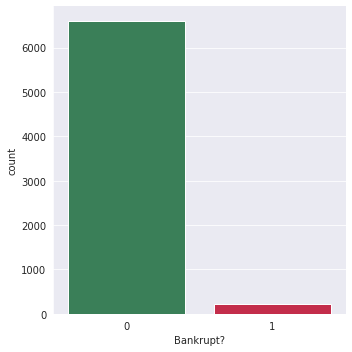

In [7]:
sns.set_style("darkgrid")
ax = sns.catplot(x='Bankrupt?', data=data, kind='count', palette=['seagreen', 'crimson'])
ax.savefig('Data_on_Bankrupt_or_Not_Bankrupt_Companies.png')
plt.show()

Within the dataset, there are few corresponding rows that indicate a company is bankrupt

## Split Data

In [8]:
bankrupt = data['Bankrupt?'].copy()
data = data.drop(columns='Bankrupt?')
data.shape

(6819, 95)

In [9]:
smote_tomek = SMOTETomek(random_state=0)
X_st, y_st = smote_tomek.fit_resample(data, bankrupt)
y_st.value_counts()

1    6562
0    6562
Name: Bankrupt?, dtype: int64

In [10]:
display(X_st.shape, y_st.shape)

(13124, 95)

(13124,)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_st, y_st, test_size=0.2, random_state=100)

print(f'''X_train shape {X_train.shape}
y_train shape {y_train.shape}
X_test shape {X_test.shape}
y_test shape {y_test.shape}''')

X_train shape (10499, 95)
y_train shape (10499,)
X_test shape (2625, 95)
y_test shape (2625,)


In [12]:
y_train.value_counts()

0    5281
1    5218
Name: Bankrupt?, dtype: int64

## Features
Train

In [13]:
# Determine columns that have binary values
[col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all() ]

['Liability-AssetsFlag', 'NetIncomeFlag']

In [14]:
X_train['Liability-AssetsFlag'].value_counts()

0    10493
1        6
Name: Liability-AssetsFlag, dtype: int64

In [15]:
X_train['NetIncomeFlag'].value_counts()

1    10499
Name: NetIncomeFlag, dtype: int64

In [16]:
# !pip install --upgrade matplotlib

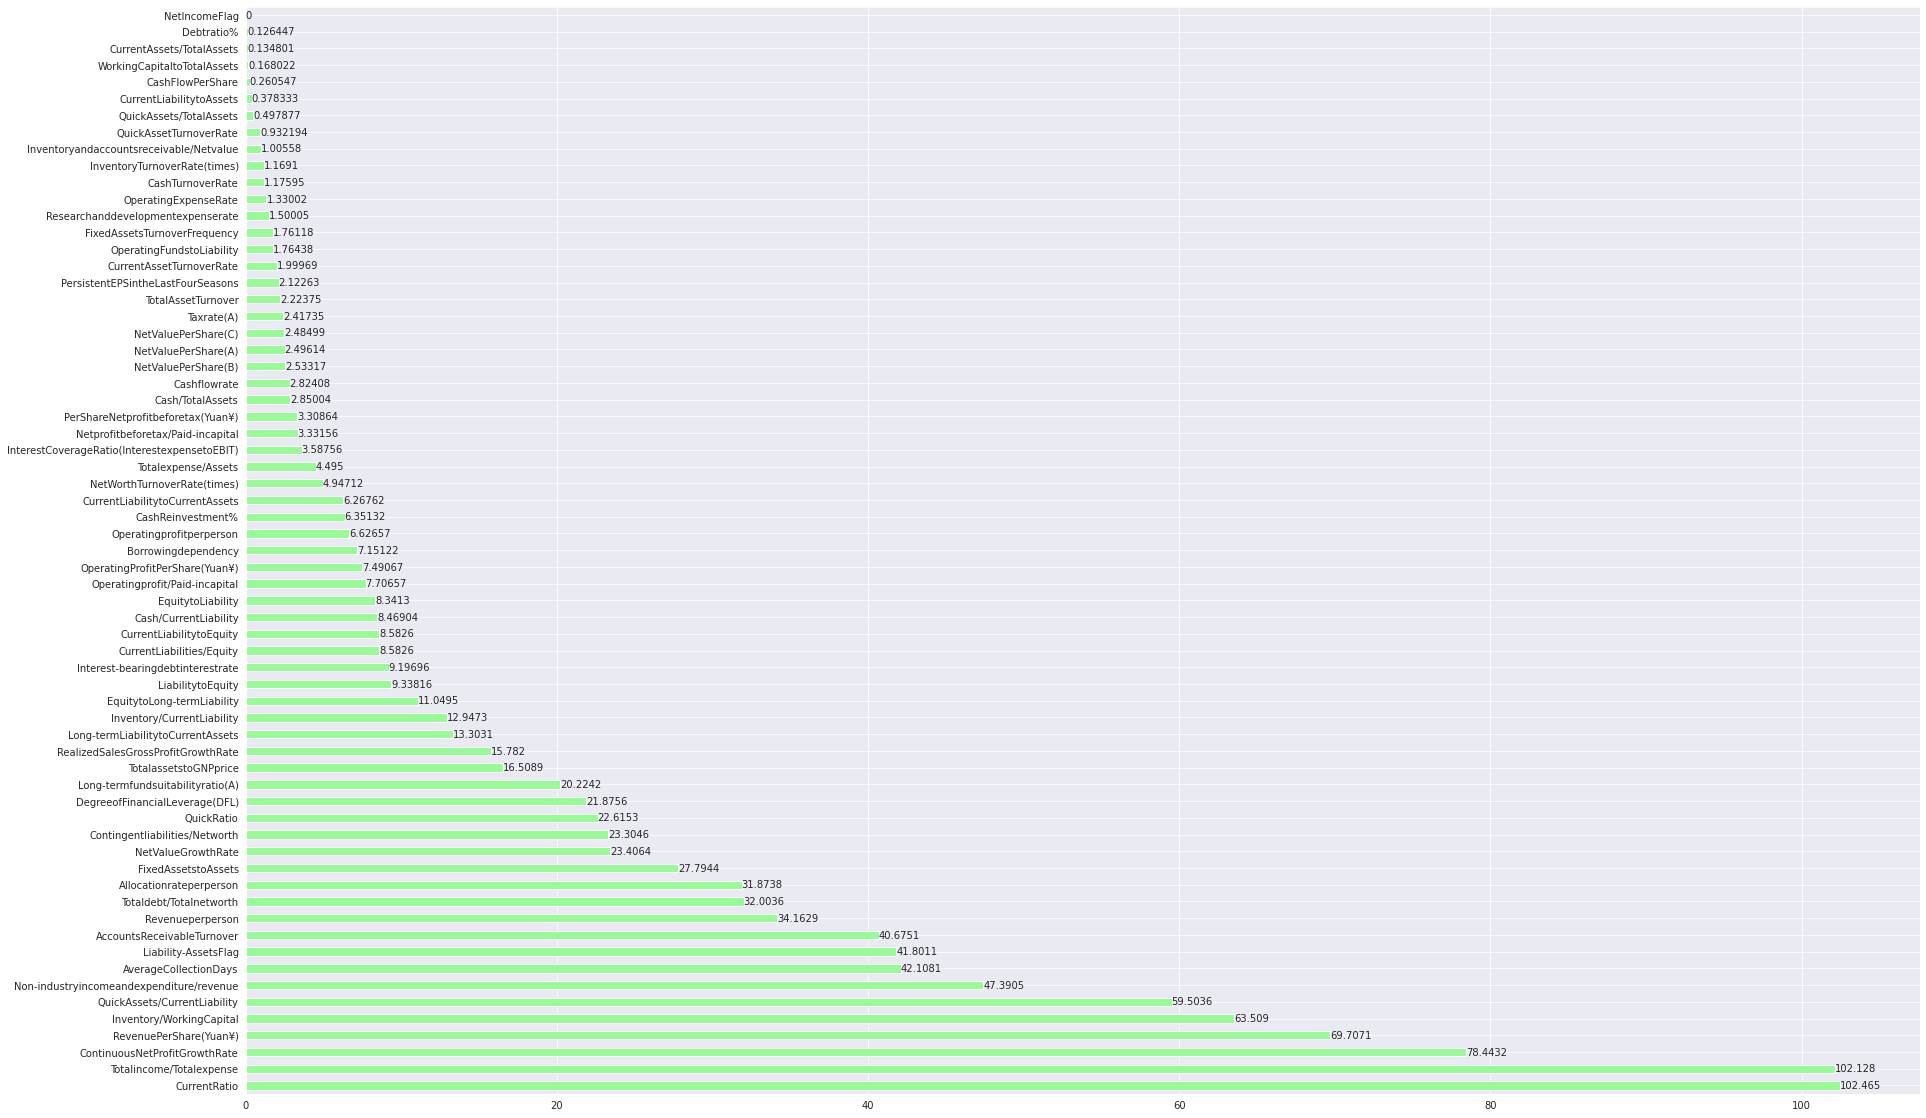

In [17]:
skew = X_train.skew()
skew_pos = skew[skew >=0].sort_values(ascending=False)
skew_neg = skew[skew <0].sort_values(ascending=True)

sns.set_style("darkgrid")

plt.figure(figsize=(30,20))
ax = skew_pos.plot.barh(color='palegreen')
ax.bar_label(ax.containers[0])
plt.savefig('positively_skewed_data.png')

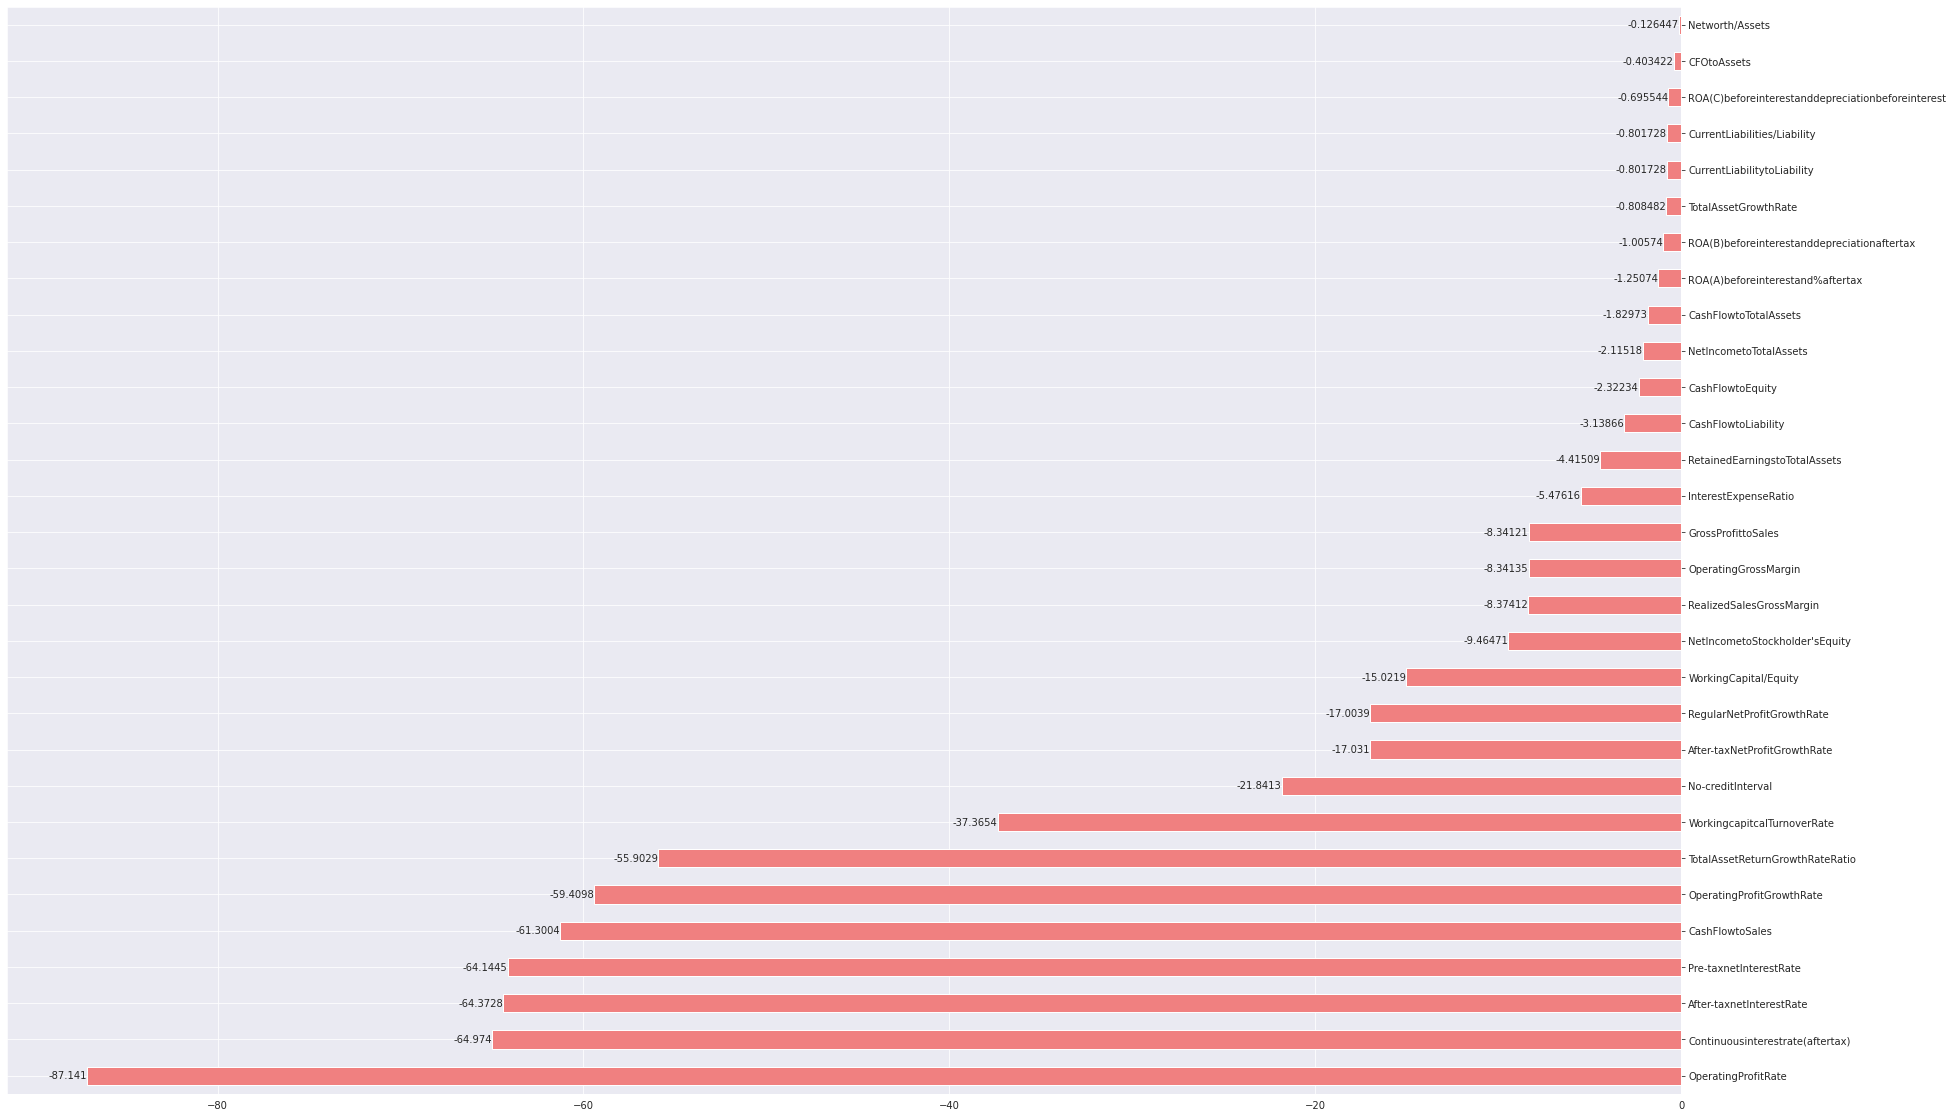

In [18]:
sns.set_style("darkgrid")

plt.figure(figsize=(30,20))
ax = skew_neg.plot.barh(color='lightcoral')
ax.bar_label(ax.containers[0])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.savefig('negatively_skewed_data.png')


In [19]:
top_skew_pos = skew_pos.head()
bottom_skew_neg = skew_neg.head()

In [20]:
def strip_violin (data_frame, x_axis, y_feat, skew,axis):
  sns.stripplot(data=data_frame, x=x_axis, y=y_feat, palette=['seagreen', 'crimson'],ax=axis)
  sns.violinplot(x=x_axis, y=y_feat, data=data_frame, inner=None, color=".8", ax=axis)
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  axis.text(0.25, 1.10, f"Skew = {round(skew,2)}", transform=axis.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
  return axis

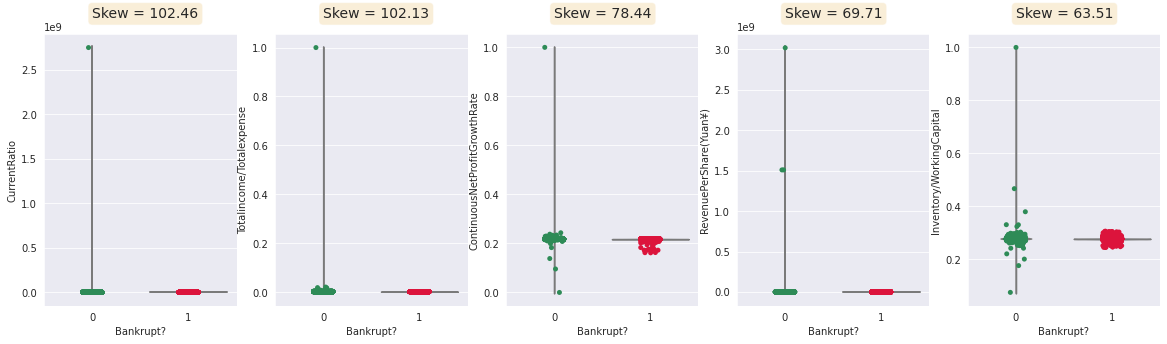

In [21]:
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(20,5))

strip_violin(X_train, y_train, top_skew_pos.index[0], top_skew_pos[0], ax0)
strip_violin(X_train, y_train, top_skew_pos.index[1], top_skew_pos[1], ax1)
strip_violin(X_train, y_train, top_skew_pos.index[2], top_skew_pos[2], ax2)
strip_violin(X_train, y_train, top_skew_pos.index[3], top_skew_pos[3], ax3)
strip_violin(X_train, y_train, top_skew_pos.index[4], top_skew_pos[4], ax4)

plt.savefig('heavily_positively_skewed_violin_strip.png')
plt.show()

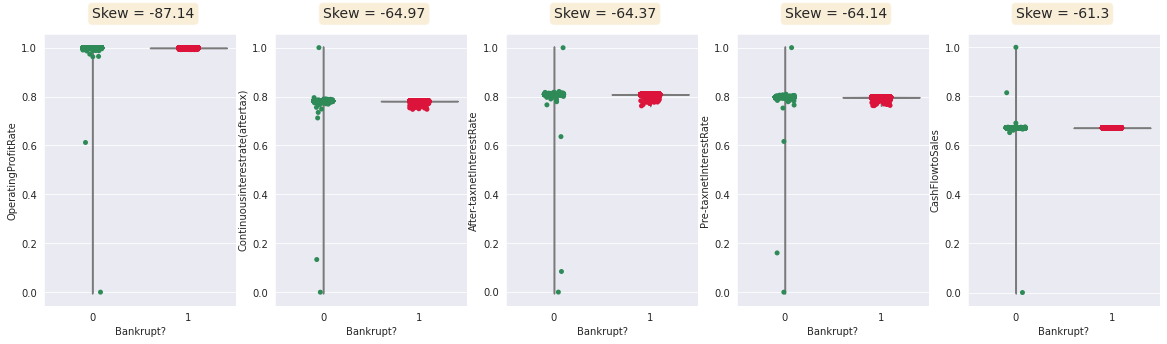

In [22]:

f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(20,5))

strip_violin(X_train, y_train, bottom_skew_neg.index[0], bottom_skew_neg[0], ax0)
strip_violin(X_train, y_train, bottom_skew_neg.index[1], bottom_skew_neg[1], ax1)
strip_violin(X_train, y_train, bottom_skew_neg.index[2], bottom_skew_neg[2], ax2)
strip_violin(X_train, y_train, bottom_skew_neg.index[3], bottom_skew_neg[3], ax3)
strip_violin(X_train, y_train, bottom_skew_neg.index[4], bottom_skew_neg[4], ax4)

plt.savefig('negatively_skewed_data_violin_strip.png')
plt.show()

## Data Types

In [23]:
def cat_num (data_frame):
  categorical_features = data_frame.select_dtypes(include = ["object", 'category']).columns
  numerical_features = data_frame.select_dtypes(include = ["float64"]).columns
  int_features = data_frame.select_dtypes(include = ['int64']).columns
  return categorical_features, numerical_features, int_features

### Train

In [24]:
features = cat_num(X_train)
print(f'''There are {len(features[0])} categorical features. {features[0]}
There are {len(features[1])} numerical features. {features[1]}
There are {len(features[2])} integer features. {features[2]}''')

There are 0 categorical features. Index([], dtype='object')
There are 93 numerical features. Index(['ROA(C)beforeinterestanddepreciationbeforeinterest',
       'ROA(A)beforeinterestand%aftertax',
       'ROA(B)beforeinterestanddepreciationaftertax', 'OperatingGrossMargin',
       'RealizedSalesGrossMargin', 'OperatingProfitRate',
       'Pre-taxnetInterestRate', 'After-taxnetInterestRate',
       'Non-industryincomeandexpenditure/revenue',
       'Continuousinterestrate(aftertax)', 'OperatingExpenseRate',
       'Researchanddevelopmentexpenserate', 'Cashflowrate',
       'Interest-bearingdebtinterestrate', 'Taxrate(A)', 'NetValuePerShare(B)',
       'NetValuePerShare(A)', 'NetValuePerShare(C)',
       'PersistentEPSintheLastFourSeasons', 'CashFlowPerShare',
       'RevenuePerShare(Yuan¥)', 'OperatingProfitPerShare(Yuan¥)',
       'PerShareNetprofitbeforetax(Yuan¥)',
       'RealizedSalesGrossProfitGrowthRate', 'OperatingProfitGrowthRate',
       'After-taxNetProfitGrowthRate', 'Regular

In [25]:
X_train[features[2]] = X_train[features[2]].astype('category')

features = cat_num(X_train)
cat_features = list(features[0])
num_features = list(features[1])
int_features = list(features[2])
print(f'''There are {len(features[0])} categorical features: {cat_features}
There are {len(features[1])} numerical features.
There are {len(features[2])} integer features: {int_features}.''')

There are 2 categorical features: ['Liability-AssetsFlag', 'NetIncomeFlag']
There are 93 numerical features.
There are 0 integer features: [].


### Test

In [26]:
features = cat_num(X_test)
print(f'''There are {len(features[0])} categorical features. {features[0]}
There are {len(features[1])} numerical features. {features[1]}
There are {len(features[2])} integer features. {features[2]}''')

There are 0 categorical features. Index([], dtype='object')
There are 93 numerical features. Index(['ROA(C)beforeinterestanddepreciationbeforeinterest',
       'ROA(A)beforeinterestand%aftertax',
       'ROA(B)beforeinterestanddepreciationaftertax', 'OperatingGrossMargin',
       'RealizedSalesGrossMargin', 'OperatingProfitRate',
       'Pre-taxnetInterestRate', 'After-taxnetInterestRate',
       'Non-industryincomeandexpenditure/revenue',
       'Continuousinterestrate(aftertax)', 'OperatingExpenseRate',
       'Researchanddevelopmentexpenserate', 'Cashflowrate',
       'Interest-bearingdebtinterestrate', 'Taxrate(A)', 'NetValuePerShare(B)',
       'NetValuePerShare(A)', 'NetValuePerShare(C)',
       'PersistentEPSintheLastFourSeasons', 'CashFlowPerShare',
       'RevenuePerShare(Yuan¥)', 'OperatingProfitPerShare(Yuan¥)',
       'PerShareNetprofitbeforetax(Yuan¥)',
       'RealizedSalesGrossProfitGrowthRate', 'OperatingProfitGrowthRate',
       'After-taxNetProfitGrowthRate', 'Regular

In [27]:
X_test[features[2]] = X_test[features[2]].astype('category')
features = cat_num(X_test)
cat_features = list(features[0])
num_features = list(features[1])
int_features = list(features[2])
print(f'''There are {len(features[0])} categorical features: {cat_features}
There are {len(features[1])} numerical features.
There are {len(features[2])} integer features: {int_features}.''')

There are 2 categorical features: ['Liability-AssetsFlag', 'NetIncomeFlag']
There are 93 numerical features.
There are 0 integer features: [].


## Train Correlations

In [28]:
def mask_corr_graph (data_frame, columnsof_interest, fig_size=(7,5), show_corr=True, fig_name='feature_corr'):
  sns.set_theme(color_codes=True)

  features_corr = data_frame[columnsof_interest].corr()

  mask = np.zeros_like(features_corr)
  mask[np.triu_indices_from(mask)] = True

  with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=fig_size)
    ax = sns.heatmap(features_corr, annot=show_corr, linewidths=0.5, cmap="RdYlGn", mask=mask)

  ax.figure.savefig(f"{fig_name}.png")
    
  return ax

In [29]:
train = pd.concat([X_train, y_train], axis=1)
train.shape

(10499, 96)

<AxesSubplot:>

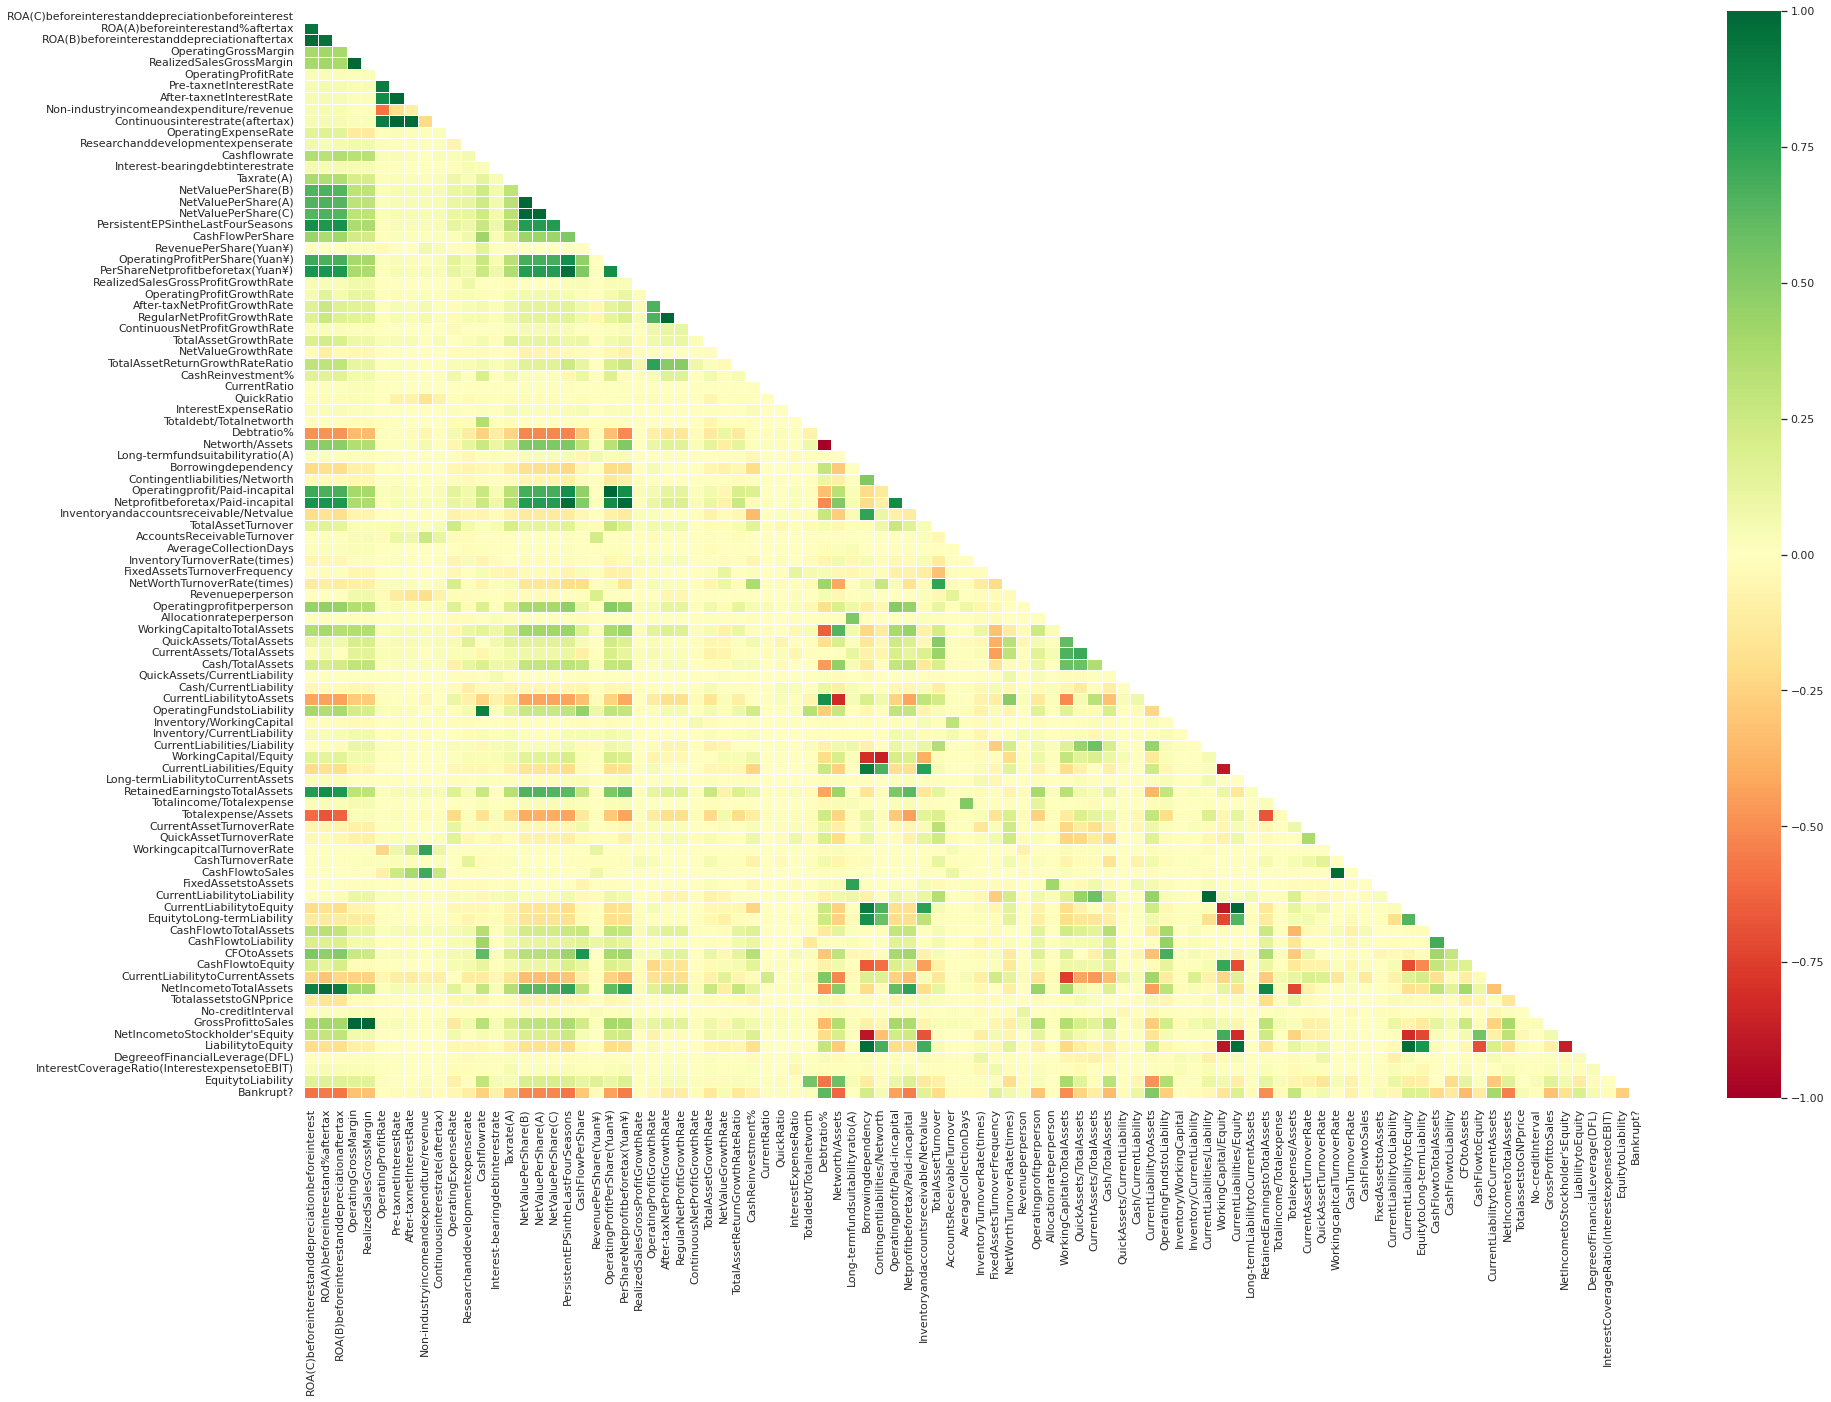

In [30]:
mask_corr_graph(train, train.columns, fig_size=(30,20), show_corr=False)

In [31]:
train_corr = train.corr()['Bankrupt?'].drop(labels=['Bankrupt?'])
top10_bottom10_corr = train_corr[(train_corr >= train_corr.quantile(q=0.90)) | 
                            (train_corr <= train_corr.quantile(q=0.10))]
top10_bottom10_corr

ROA(C)beforeinterestanddepreciationbeforeinterest   -0.581319
ROA(A)beforeinterestand%aftertax                    -0.561713
ROA(B)beforeinterestanddepreciationaftertax         -0.576042
NetValuePerShare(B)                                 -0.518922
NetValuePerShare(A)                                 -0.518460
PersistentEPSintheLastFourSeasons                   -0.574820
PerShareNetprofitbeforetax(Yuan¥)                   -0.549500
Debtratio%                                           0.621892
Networth/Assets                                     -0.621892
Borrowingdependency                                  0.213518
Netprofitbeforetax/Paid-incapital                   -0.553715
FixedAssetsTurnoverFrequency                         0.157484
CurrentLiabilitytoAssets                             0.515075
CurrentLiabilities/Equity                            0.176496
Totalexpense/Assets                                  0.278046
CurrentLiabilitytoEquity                             0.176496
Equityto

## Make Bankrupt? A Category

In [32]:
y_train = y_train.astype('category')
y_train

11534    1
9952     1
7523     1
332      0
12339    1
        ..
79       0
12119    1
8039     1
6936     1
5640     0
Name: Bankrupt?, Length: 10499, dtype: category
Categories (2, int64): [0, 1]

In [33]:
y_test = y_test.astype('category')
y_test

4967     0
689      0
11490    1
7493     1
11805    1
        ..
11569    1
7095     1
10470    1
3111     0
11949    1
Name: Bankrupt?, Length: 2625, dtype: category
Categories (2, int64): [0, 1]

## Pipeline: Preprocesseor

In [49]:
preprocessor = ColumnTransformer(transformers=[('scaler', StandardScaler(), num_features)])


# Models

### Model Stats

In [50]:
from operator import mod
def evaluating_model (y_true, y_pred, model_name, train_test):
  print(f'''
  {model_name} for {train_test} Data
  MSE: {round(mean_squared_error(y_true, y_pred), 4)}
  RMSE: {round((mean_squared_error(y_true, y_pred)**0.5),4)}
  MAE: {round(mean_absolute_error(y_true, y_pred),4)}
  R_SQR: {round(r2_score(y_true, y_pred),4)}
  EXV: {round(explained_variance_score(y_true, y_pred),4)}
  ME: {round(max_error(y_true, y_pred),4)}
  RMSLE: {round((mean_squared_log_error(y_true, y_pred)**0.5),4)}
  ''')
  return

  # Confusion matrix {confusion_matrix(x_data,y_pred)}
def eval_classification (y_pred, y_true, x_data, model_name, train_test):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

  print(f'''
  {model_name} for {train_test} Data
  Accuracy score {round(accuracy_score(y_true, y_pred),4)}
  F1-Score {round(f1_score(y_true, y_pred),4)}
  FPR {fpr}
  tpr {tpr}
  ''')

  f, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax0, 
                                   name=f'{model_name} {train_test} ROC_Curve')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax1, 
                                          name=f'{model_name} {train_test} Precision/Recall')
  plt.savefig(f'{model_name}_{train_test}_roc_prec_rec_curves.png')
  plt.show()
  return

## Pipeline: Logistic Regression

In [61]:
LR_pipe = Pipeline(steps= [('preprocessor', preprocessor),
                            ('regressor', LogisticRegression(max_iter=400))
])

In [65]:
start = time()
lr_model = LR_pipe.fit(X_train, y_train)
end = time()
print(f"Runtime for LR {end-start} seconds")

Runtime for LR 1.1017818450927734 seconds


In [53]:
train_pred_lr = lr_model.predict(X_train)
test_pred_lr = lr_model.predict(X_test)

### LG Evaluation


  LG for Train Data
  MSE: 0.0903
  RMSE: 0.3005
  MAE: 0.0903
  R_SQR: 0.6388
  EXV: 0.6392
  ME: 1.0
  RMSLE: 0.2083
  

  LG for Train Data
  Accuracy score 0.9097
  F1-Score 0.9101
  FPR [0.         0.09960235 1.        ]
  tpr [0.        0.9191261 1.       ]
  


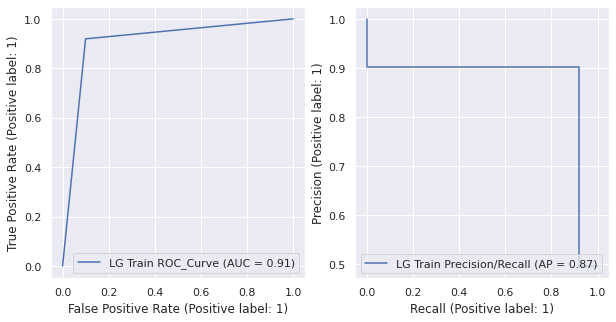

---------------------

  LG for Test Data
  MSE: 0.0971
  RMSE: 0.3117
  MAE: 0.0971
  R_SQR: 0.6112
  EXV: 0.6118
  ME: 1.0
  RMSLE: 0.216
  

  LG for Test Data
  Accuracy score 0.9029
  F1-Score 0.9063
  FPR [0.         0.11241218 1.        ]
  tpr [0.         0.91741071 1.        ]
  


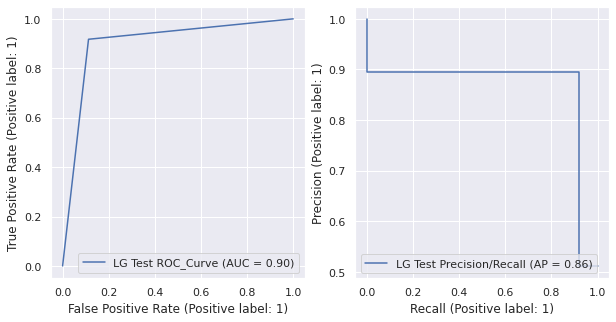

In [54]:
evaluating_model(y_train, train_pred_lr,'LG', 'Train')
eval_classification(train_pred_lr, y_train, X_train, 'LG', 'Train')

print("---------------------")
evaluating_model(y_test, test_pred_lr,'LG', 'Test')
eval_classification(test_pred_lr, y_test, X_test, 'LG', 'Test')

## Pipeline: Linear Support Vector Classification

In [55]:
LSVC_pipe = Pipeline(steps= [('preprocessor', preprocessor),
                            ('linearSVC', LinearSVC(max_iter=140000))
])

In [73]:
start = time()
LSVC_model = LSVC_pipe.fit(X_train, y_train)
end = time()
print(f"Runtime for LSVC {end-start}")

Runtime for LSVC 158.61815333366394


In [66]:
train_pred_LSVC = LSVC_model.predict(X_train)
test_pred_LSVC = LSVC_model.predict(X_test)

### LSVC Evaluation


  LSVC for Train Data
  MSE: 0.0894
  RMSE: 0.2991
  MAE: 0.0894
  R_SQR: 0.6422
  EXV: 0.643
  ME: 1.0
  RMSLE: 0.2073
  

  LSVC for Train Data
  Accuracy score 0.9106
  F1-Score 0.9112
  FPR [0.         0.10244272 1.        ]
  tpr [0.         0.92372557 1.        ]
  


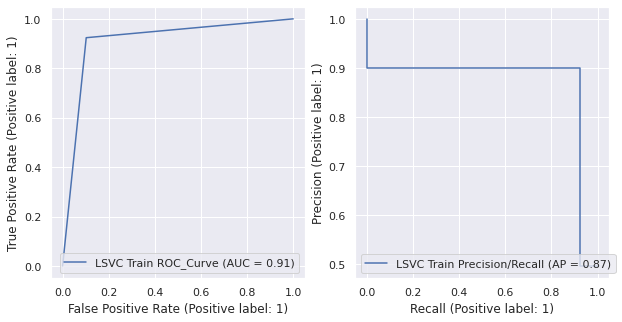

---------------------

  LSVC for Test Data
  MSE: 0.093
  RMSE: 0.3049
  MAE: 0.093
  R_SQR: 0.628
  EXV: 0.6292
  ME: 1.0
  RMSLE: 0.2113
  

  LSVC for Test Data
  Accuracy score 0.907
  F1-Score 0.9108
  FPR [0.         0.11319282 1.        ]
  tpr [0.         0.92633929 1.        ]
  


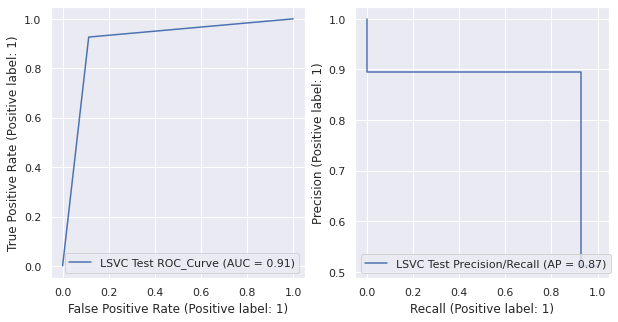

In [67]:
evaluating_model(y_train, train_pred_LSVC,'LSVC', 'Train')
eval_classification(train_pred_LSVC, y_train, X_train, 'LSVC', 'Train')

print("---------------------")
evaluating_model(y_test, test_pred_LSVC, 'LSVC', 'Test')
eval_classification(test_pred_LSVC, y_test, X_test, 'LSVC', 'Test')

## Pipeline: Gaussian Naive Bayes

In [68]:
GNB_pipe = Pipeline(steps= [('preprocessor', preprocessor),
                            ('GaussianNB', GaussianNB())
])

In [69]:
start = time()
GNB_model = GNB_pipe.fit(X_train, y_train)
end = time()
print(f"Runtime for GNB {end-start} seconds")

Runtime for GNB 0.042063236236572266 seconds


In [70]:
train_pred_GNB = GNB_model.predict(X_train)
test_pred_GNB = GNB_model.predict(X_test)

### GNB Evaluation


  GNB for Train Data
  MSE: 0.3178
  RMSE: 0.5638
  MAE: 0.3178
  R_SQR: -0.2714
  EXV: 0.0572
  ME: 1.0
  RMSLE: 0.3908
  

  GNB for Train Data
  Accuracy score 0.6822
  F1-Score 0.7518
  FPR [0.         0.60083318 1.        ]
  tpr [0.         0.96857033 1.        ]
  


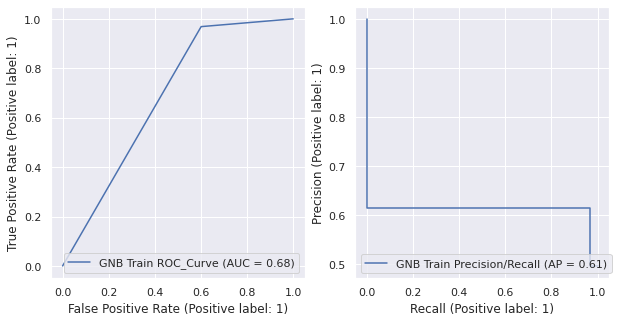

---------------------

  GNB for Test Data
  MSE: 0.3112
  RMSE: 0.5579
  MAE: 0.3112
  R_SQR: -0.2457
  EXV: 0.0837
  ME: 1.0
  RMSLE: 0.3867
  

  GNB for Test Data
  Accuracy score 0.6888
  F1-Score 0.7626
  FPR [0.        0.6128025 1.       ]
  tpr [0.         0.97619048 1.        ]
  


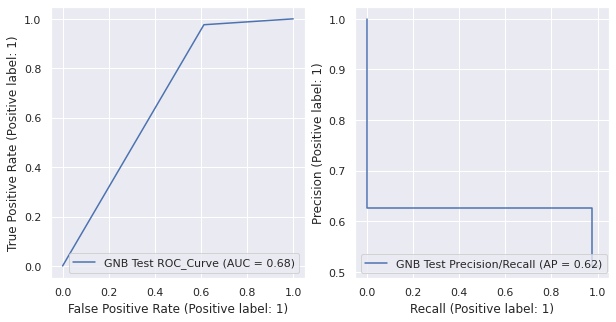

In [71]:
evaluating_model(y_train, train_pred_GNB, 'GNB', 'Train')
eval_classification(train_pred_GNB, y_train, X_train,'GNB', 'Train')

print("---------------------")
evaluating_model(y_test, test_pred_GNB,'GNB', 'Test')
eval_classification(test_pred_GNB, y_test, X_test, 'GNB', 'Test')

## Random Forest Classifier

In [75]:
RFC_pipe = Pipeline(steps= [('preprocessor', preprocessor),
                            ('RandomForestClassifier', RandomForestClassifier())
])

In [76]:
start = time()
RFC_model = RFC_pipe.fit(X_train, y_train)
end = time()
print(f"Runtime for GNB {end-start} seconds")

Runtime for GNB 10.200640678405762 seconds


In [77]:
train_pred_RFC = RFC_model.predict(X_train)
test_pred_RFC = RFC_model.predict(X_test)

### RFC Evaluation


  RFC for Train Data
  MSE: 0.0
  RMSE: 0.0
  MAE: 0.0
  R_SQR: 1.0
  EXV: 1.0
  ME: 0.0
  RMSLE: 0.0
  

  RFC for Train Data
  Accuracy score 1.0
  F1-Score 1.0
  FPR [0. 0. 1.]
  tpr [0. 1. 1.]
  


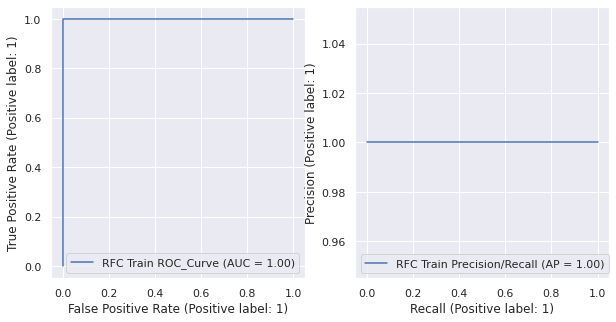

---------------------

  RFC for Test Data
  MSE: 0.0221
  RMSE: 0.1486
  MAE: 0.0221
  R_SQR: 0.9116
  EXV: 0.9125
  ME: 1.0
  RMSLE: 0.103
  

  RFC for Test Data
  Accuracy score 0.9779
  F1-Score 0.9787
  FPR [0.         0.03825137 1.        ]
  tpr [0.         0.99330357 1.        ]
  


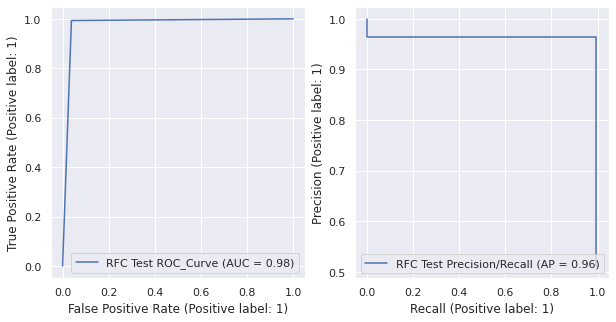

In [81]:
evaluating_model(y_train, train_pred_RFC, 'RFC', 'Train')
eval_classification(train_pred_RFC, y_train, X_train,'RFC', 'Train')

print("---------------------")
evaluating_model(y_test, test_pred_RFC,'RFC', 'Test')
eval_classification(test_pred_RFC, y_test, X_test, 'RFC', 'Test')

## Gradient Boosted Trees

In [79]:
GBT_pipe = Pipeline(steps= [('preprocessor', preprocessor),
                            ('GradientBoostedTrees', GradientBoostingClassifier())
])

In [80]:
start = time()
GBT_model = GBT_pipe.fit(X_train, y_train)
end = time()
print(f"Runtime for GNB {end-start} seconds")

Runtime for GNB 29.086556434631348 seconds


In [82]:
train_pred_GBT = GBT_model.predict(X_train)
test_pred_GBT = GBT_model.predict(X_test)

### GBT Evaluation


  GBT for Train Data
  MSE: 0.0297
  RMSE: 0.1724
  MAE: 0.0297
  R_SQR: 0.8811
  EXV: 0.8819
  ME: 1.0
  RMSLE: 0.1195
  

  GBT for Train Data
  Accuracy score 0.9703
  F1-Score 0.9705
  FPR [0.       0.043363 1.      ]
  tpr [0.         0.98409352 1.        ]
  


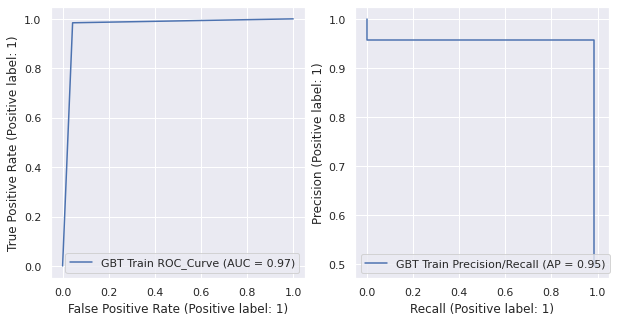

---------------------

  GBT for Test Data
  MSE: 0.045
  RMSE: 0.212
  MAE: 0.045
  R_SQR: 0.8201
  EXV: 0.8222
  ME: 1.0
  RMSLE: 0.147
  

  GBT for Test Data
  Accuracy score 0.955
  F1-Score 0.9571
  FPR [0.         0.06947697 1.        ]
  tpr [0.         0.97842262 1.        ]
  


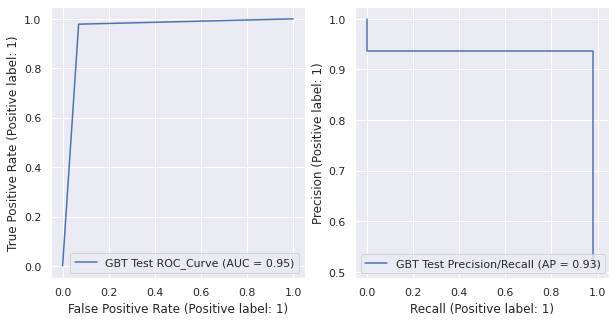

In [83]:
evaluating_model(y_train, train_pred_GBT, 'GBT', 'Train')
eval_classification(train_pred_GBT, y_train, X_train,'GBT', 'Train')

print("---------------------")
evaluating_model(y_test, test_pred_GBT,'GBT', 'Test')
eval_classification(test_pred_GBT, y_test, X_test, 'GBT', 'Test')

## Extra Tree Classifier

In [107]:
ETC_pipe = Pipeline(steps= [('preprocessor', preprocessor),
                            ('ExtraTreeClassifier', ExtraTreesClassifier())
])

In [108]:
start = time()
ETC_model = ETC_pipe.fit(X_train, y_train)
end = time()
print(f"Runtime for ETC {end-start} seconds")

Runtime for ETC 1.3205389976501465 seconds


In [111]:
train_pred_ETC = ETC_model.predict(X_train)
test_pred_ETC = ETC_model.predict(X_test)

### ETC Evaluation


  ETC for Train Data
  MSE: 0.0
  RMSE: 0.0
  MAE: 0.0
  R_SQR: 1.0
  EXV: 1.0
  ME: 0.0
  RMSLE: 0.0
  

  ETC for Train Data
  Accuracy score 1.0
  F1-Score 1.0
  FPR [0. 0. 1.]
  tpr [0. 1. 1.]
  


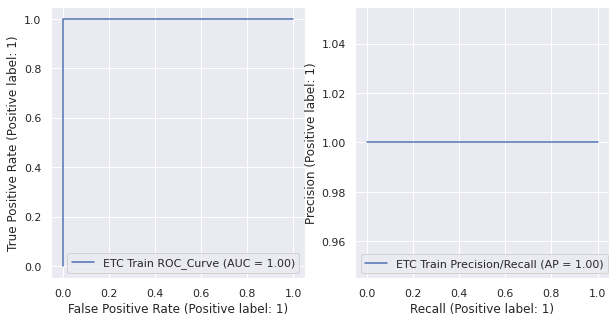

---------------------

  ETC for Test Data
  MSE: 0.0229
  RMSE: 0.1512
  MAE: 0.0229
  R_SQR: 0.9085
  EXV: 0.9101
  ME: 1.0
  RMSLE: 0.1048
  

  ETC for Test Data
  Accuracy score 0.9771
  F1-Score 0.9781
  FPR [0.         0.04371585 1.        ]
  tpr [0.         0.99702381 1.        ]
  


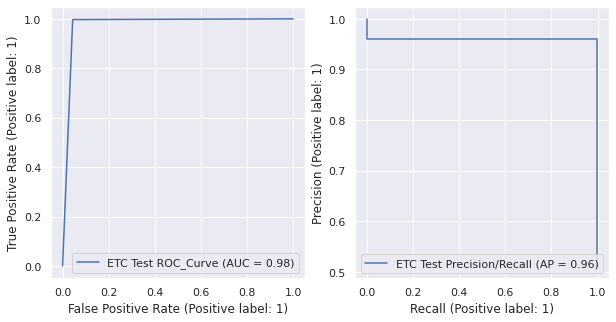

In [112]:
evaluating_model(y_train, train_pred_ETC, 'ETC', 'Train')
eval_classification(train_pred_ETC, y_train, X_train,'ETC', 'Train')

print("---------------------")
evaluating_model(y_test, test_pred_ETC,'ETC', 'Test')
eval_classification(test_pred_ETC, y_test, X_test, 'ETC', 'Test')